# **CS 470 Assignment 1**
### Implementing a Multi-layer Perceptron (MLP)

#### In this exercise, you will develop a neural network with fully-connected layers to perform image classification, and test it out on the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset. 

# Download the data


In [78]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 
!pip install scipy

--2022-09-23 14:36:41--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  73.6MB/s    in 2.2s    

2022-09-23 14:36:45 (73.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Load the data

In [79]:
import pickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [80]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the MLP classifier.   
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/content/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape the data
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


####*In* this work, fully-connected (linear) layers are used, i.e. the layers can be defined as $f(x) = Wx + b$ where $W$ is the weight matrix of the layer, $x$ is its input, and $b$ is the bias. The ReLU function is essentially defined as $f(x) = \max(0, x)$.


In [81]:
def sigmoid(x):
  return 1./(1.+np.exp(-x))

class MLP(object):
  """
  A multi-layer fully-connected neural network has an input dimension of
  d, a hidden layer dimension of h, and performs classification over c classes.
  You must train the network with a softmax loss function and L1 regularization on the
  weight matrices. The network uses a LeakyReLU nonlinearity after the first fully
  -connected layer.

  The network has the following architecture:

  Input - Linear layer - LeakyReLU - Linear layer - Softmax

  The outputs of the network are the labels for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, activation, std=1e-4):
    """
    An initialization function

    Parameters
    ----------
    input_size: integer
        the dimension d of the input data.                          
    hidden_size: integer
        the number of neurons h in the hidden layer.               
    output_size: integer
        the number of classes c.                                   
    activation: string
        activation method name
    std: float
        standard deviation
    """
    # w1: weights for the first linear layer                                    
    # b1: biases for the first linear layer                                     
    # w2: weights for the second linear layer                                   
    # b2: biases for the second linear layer                                    

    self.params = {}
    self.params['w1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros((1,hidden_size))                                    # should I change this to (1, hidden_size)
    self.params['w2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros((1, output_size))

    self.leaky_relu_c = 0.01
    self.activation_method = ['ReLU','LeakyReLU','SWISH'].index(activation)
    print("Selected using "+['ReLU','LeakyReLU','SWISH'][self.activation_method])
      

  def forward_pass(self, x, w1, b1, w2, b2):
    """
    A forward pass function

    Returns
    -------    
    out: 

    cache: 

    """
    h1     = None  # the activation after the first linear layer
    y1, y2 = None, None  # outputs from the first & second linear layers

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Design the fully-connected neural network and compute its forward.  #
    #       pass output,                                                        #
    #        Input - Linear layer - LeakyReLU - Linear layer.                   #
    #       You have use predefined variables above                             #
    #                                                                           #
    y1 = np.matmul(x, w1) + b1                                                                     #
                                                                              #
    if self.activation_method == 0:                                           #
      h1 =  np.maximum(y1, 0)                                                            #
    elif self.activation_method == 1: 
      h1 = np.maximum(self.leaky_relu_c*y1, y1)                                        #
      #h1 =  np.array([max(i, self.leaky_relu_c*i) for i in y1])
      #h1 = np.array([self.leaky_relu_c * i if i < 0 else i for i in y1])  -> also possible 
    else:                                                                     #
      h1 =  y1 * sigmoid(y1)     # swish                                                        #
    #                                                                           #
    y2 = np.matmul(h1, w2) + b2                                                                     #
    #                                                                           #
    #  END OF YOUR CODE                                                         #
    #############################################################################
    
    out   = y2
    cache = (y1, h1) # intermediate values

    return out, cache


  def softmax_loss(self, x, y):
    """
    Compute the loss and gradients for a softmax classifier

    Returns
    -------    
    loss: 

    dx: 


    """
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Compute the softmax classification loss and its gradient.           #
    # The softmax loss is also known as cross-entropy loss.
                         # x - matrix of size input size m * dimensions n
    m, n = x.shape
    xmax = x.max(axis = -1, keepdims = True)
    stable = x - xmax
    p    =   np.exp(stable)/np.sum(np.exp(stable), axis = -1, keepdims=True) # for stable softmax.                                             #
    #n    = y.shape[0]                                                                   #
    summ = -1 * np.log(p[range(m),y])  
    loss = np.sum(summ)/m                                                                 #
    # 
    y_one_hot = np.zeros(x.shape)
    y_one_hot[np.arange(m), y]  = 1 
                                                                           #
    dx = (p - y_one_hot)/(x.shape[0]) 
                                                                        #
    #  END OF YOUR CODE                                                         #  
    #############################################################################

    return loss, dx


  def backward_pass(self, dY2_dLoss, x, w1, y1, h1, w2):
    """
    A backward pass function

    Returns
    -------    
    grads: 

    
    """
    grads = {}

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################
    # TODO: Compute the backward pass, computing the derivatives of the weights #
    # and biases. Store the results in the grads dictionary. For example,       #
    # the gradient on W1 should be stored in grads['w1'] and be a matrix of same#
    # size                                                                      #
    #                                                                           #
    #without regularization                                                     #
    grads['w2'] = np.dot(h1.T,dY2_dLoss)                                       # 
    grads['b2'] = np.sum(dY2_dLoss, axis=0)    # axis = 0 we sum down the column - for each feature                                #
                                                                               #
    if self.activation_method == 0:
      dH1_dLoss = np.matmul(dY2_dLoss, w2.T)
      indx = y1 < 0
      one_matrix = np.ones_like(y1)
      one_matrix[indx] = 0
                                    #                                                                      #
      dY1_dLoss = dH1_dLoss * one_matrix                                                       #

    
    elif self.activation_method == 1:
      dH1_dLoss = np.matmul(dY2_dLoss, w2.T)
      indx = y1 <= 0
      one_matrix = np.ones_like(y1)
      one_matrix[indx] = self.leaky_relu_c
      dY1_dLoss = dH1_dLoss * one_matrix                                           #
    #                                                                           #
    #  dH1_dLoss = np.matmul(w2, dy1_dloss)    # Leaky ReLU                                               # 
    #  inb =  numpy.full(h1.shape, self.leaky_relu_c)                                                                   #
    #  inb[h1>0]=1                                                              #
    #  dY1_dLoss =                                                              #
    else:                                                                      #
    #                                                                           #
      dH1_dLoss =  np.matmul(dY2_dLoss, w2.T) # SWISH                                                    #
      swish_y1 = y1 * sigmoid(y1)                                                              #
      dY1_dH1 =  swish_y1 * (1 - sigmoid(y1)) + sigmoid(y1)                                                              #
      dY1_dLoss =  dH1_dLoss * dY1_dH1                                                            #  
    #                                                                           #
    grads['w1'] = np.dot(x.T, dY1_dLoss)                                                           #
    grads['b1'] = np.sum(dY1_dLoss, axis = 0)                                                             #
    #                                                                           #
    #  END OF YOUR CODE                                                         #
    #############################################################################
    
    return grads


  def loss(self, x, y=None, regular=0.0, enable_margin=False):
    """
    A loss function that returns the loss and gradients of the fully-connected 
    neural network. This function requires designing forward and backward passes.
    
    If y is None, it returns a matrix labelsof shape (n, c) where labels[i, c] 
    is the label score for class c on input x[i]. Otherwise, it returns a tuple
    of loss and grads.

    Parameters
    ----------
    x:  matrix     
        an input data of shape (n, d). Each x[i] is a training sample.
    y:  vector     
        a vector of training labels. Each y[i] is an integer in the range 
        0 <= y[i] < c. y[i] is the label for x[i]. If it is passed then we
        return the loss and gradients.
    regular: float
        regularization strength.
    enable_margin: Bool
        enable to use soft-margin softmax
    
    Returns
    -------    
    loss: 
        Loss (data loss and regularization loss) for this batch of training 
        samples.
    grads: 
        Dictionary mapping parameter names to gradients of those parameters with
        respect to the loss function; has the same keys as self.params.
    """
    # Variables
    n, d   = x.shape # input dimensions
    w1, b1 = self.params['w1'], self.params['b1']
    w2, b2 = self.params['w2'], self.params['b2']
    h1     = None  # the activation after the first linear layer
    y1, y2 = None, None  # outputs from the first & second linear layers

    # Compute the forward pass
    out, cache = self.forward_pass(x,w1,b1,w2,b2)
    y2       = out
    (y1, h1) = cache

    # If the targets are not given then jump out, we're done
    if y is None:
      return y2

    # Compute the loss
    loss, dY2_dLoss = self.softmax_loss(y2, y)

    # Compute the backward pass
    grads = self.backward_pass(dY2_dLoss, x, w1, y1, h1, w2)

    #############################################################################
    # (OPTION) PLACE YOUR CODE HERE                                             #
    #############################################################################
    # TODO: Implement weight regularization                                     #
    loss += np.sum(np.square(w2)) + np.sum(np.square(w1))
    loss *= regular                                                                  #
    #add regularization effect                                                  #
    grads['w2'] +=  regular * w2                                                           #
    grads['w1'] +=  regular * w1                                                           #
    #  END OF YOUR CODE                                                         #
    #############################################################################

    return loss, grads


  def train(self, x, y, x_v, y_v,
            eta=1e-3, lamdba=0.95,
            regular=1e-5, num_iters=50,
            batch_size=100, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - x: A numpy array of shape (n, d) giving training data.
    - y: A numpy array f shape (n,) giving training labels; y[i] = C means that
      x[i] has label C, where 0 <= C < c.
    - x_v: A numpy array of shape (n_v, d) giving validation data.
    - y_v: A numpy array of shape (n_v,) giving validation labels.
    - eta: Scalar giving learning rate for optimization.
    - lamdba: Scalar giving factor used to decay the learning rate
      after each epoch.
    - regular: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = x.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use Stochastic Gradient Descent (SGD) to optimize the parameters in 
    # self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      x_batch = None
      y_batch = None

      #########################################################################
      # PLACE YOUR CODE HERE                                                  #
      #########################################################################
      # TODO: Create a random minibatch of training data and labels, storing  #
      # them in x_batch and y_batch respectively.                             #
      #                                                                       #
      idx =    np.random.choice(range(num_train), batch_size, replace = False)                                                         #
      x_batch = x[idx]                                                            #
      y_batch = y[idx]                                                          #
      #                                                                       #
      #  END OF YOUR CODE                                                     #
      #########################################################################

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(x_batch, y=y_batch, regular=regular)
      loss_history.append(loss)

      #########################################################################
      # PLACE YOUR CODE HERE                                                  #
      #########################################################################
      # TODO: Update the parameters of the network stored in self.params by   #
      # using the gradients in the grads dictionary. For that, use stochastic #
      # gradient descent.                                                     #
      #                                                                       #
      self.params['w1'] -=   eta * grads['w1']                                                #
      self.params['w2'] -=   eta * grads['w2']                               #
      self.params['b1'] -=   eta * grads['b1']                                               #
      self.params['b2'] -=   eta * grads['b2']                                               #
      #                                                                       #
      #  END OF YOUR CODE                                                     #
      #########################################################################

      if verbose and it % 100 == 0:
        print('The #iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(x_batch) == y_batch).mean()
        val_acc = (self.predict(x_v) == y_v).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        eta *= lamdba

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, x):
    """
    Use the trained weights of this MLP network to predict labels for
    data points. For each data point we predict labels for each of the C
    classes, and assign each data point to the class with the highest label 
    score.

    Inputs:
    - x: A numpy array of shape (n, d) giving n d-dimensional data points to
      classify.

    Returns:
    - y_pr: A numpy array of shape (n,) giving predicted labels for each of
      the elements of x. For all i, y_pred[i] = c means that x[i] is predicted
      to have class C, where 0 <= C < c.
    """
    y_pr = None

    ###########################################################################
    # PLACE YOUR CODE HERE                                                    #
    ###########################################################################
    # TODO: Implement the predict function  
    w1,b1,w2,b2 = self.params['w1'],self.params['b1'],self.params['w2'],self.params['b2']                                  #
    out, _ =  self.forward_pass(x, w1, b1, w2, b2)                                                               #
    y_pr =    out.argmax(axis=-1)                                                               #
    #                                                                         #
    # END OF YOUR CODE                                                        #
    ###########################################################################

    return y_pr


# Train a model
To train our model, we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [83]:
np.random.seed(1)
input_size = 32 * 32 * 3
hidden_size = 1024 
num_classes = 10
activation = 'ReLU' # Select one in [ReLU, LeakyReLU, SWISH]
net_mlp = MLP(input_size, hidden_size, num_classes, activation) 

# Train the network
stats = net_mlp.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=600,
            eta=1e-3, lamdba=0.95,
            regular=0.5, verbose=True)

# Predict on the validation set
val_acc = (net_mlp.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

Selected using ReLU
The #iteration 0 / 1000: loss 1.167057
The #iteration 100 / 1000: loss 0.959255
The #iteration 200 / 1000: loss 0.890003
The #iteration 300 / 1000: loss 0.856948
The #iteration 400 / 1000: loss 0.832900
The #iteration 500 / 1000: loss 0.871659
The #iteration 600 / 1000: loss 0.838150
The #iteration 700 / 1000: loss 0.799865
The #iteration 800 / 1000: loss 0.801545
The #iteration 900 / 1000: loss 0.791809
Validation accuracy:  0.492


# Visualization


You have to plot the loss function and the accuracies on the training and validation sets.Also, visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

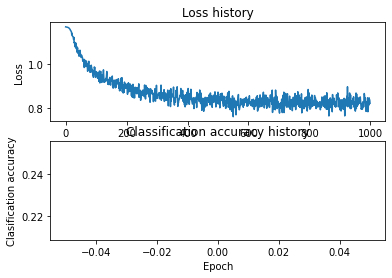

In [84]:
import matplotlib.pyplot as plt
# Plot the loss function and train / validation accuracies
def showStats(stats):
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(stats['train_acc_history'], label='train')
    plt.plot(stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()
    
showStats(stats)

In [85]:
def visualize_grid(xs, ubound=255.0, padding=1):
  """
  Reshape an image data of 4D tensor to a grid for the better understanding and visualization.

  Inputs:
  - xs: Data of shape (n, h, w, c)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (n, h, w, c) = xs.shape
  grid_size = int(ceil(sqrt(n)))
  grid_height = h * grid_size + padding * (grid_size - 1)
  grid_width = w * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, c))
  next_idx = 0
  y0, y1 = 0, h
  for y in range(grid_size):
    x0, x1 = 0, w
    for x in range(grid_size):
      if next_idx < n:
        img = xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += w + padding
      x1 += w + padding
    y0 += h + padding
    y1 += h + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

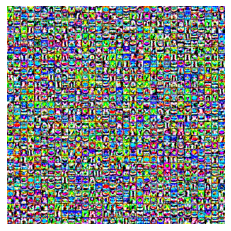

In [86]:
import math
from math import *

def show_net_weights(net):
  w1 = net_mlp.params['w1']

  ###########################################################################
  # PLACE YOUR CODE HERE                                                    #
  ###########################################################################
  # TODO: Implement the weight visualization
  w1 = (w1.T).reshape(hidden_size,32,32,3)
  index1 = w1==0
  index2 = w1<0
  index3 = w1>0                                #
  w1[index1] = 0.5
  w1[index2] = 0
  w1[index3] = 1
  my_grid = visualize_grid(w1)                                                                  #
  # END OF YOUR CODE                                                        #
  ###########################################################################

  plt.gca().axis('off')
  plt.imshow(my_grid)

show_net_weights(net_mlp)

# Tune your hyperparameters

We will tune the hyperparameters by developing intuition for how they affect the final performance. By doing so, we want you to get a lot of practice. Below, you should experiment with different values of various hyperparameters, including learning rate, number of hidden layers, and regularization strength (Option). 

**Expected results**. You should be aim to achieve a classification accuracy of greater than 49.5% on the validation set (with ReLU). Our best network gets over 52% on the validation set.


Selected using ReLU
The #iteration 0 / 1000: loss 1.167066
The #iteration 100 / 1000: loss 0.975055
The #iteration 200 / 1000: loss 0.923771
The #iteration 300 / 1000: loss 0.848774
The #iteration 400 / 1000: loss 0.859770
The #iteration 500 / 1000: loss 0.799037
The #iteration 600 / 1000: loss 0.842932
The #iteration 700 / 1000: loss 0.833184
The #iteration 800 / 1000: loss 0.830402
The #iteration 900 / 1000: loss 0.806814
[6 1 9 ... 4 1 8]
hs 1.024000e+03 lr 1.000000e-03 regular 5.000000e-01 train accuracy: 0.544939 val accuracy: 0.500000
best validation accuracy achieved during cross-validation: 0.500000


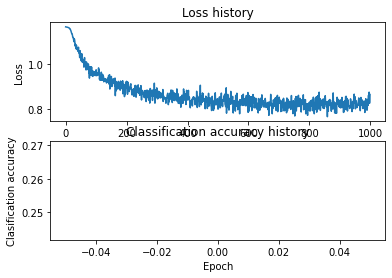

In [87]:
"""
Tune hyperparameters using the validation set. Store your best trained  
model in best_net.                                                                                  
"""
from enum import EnumMeta
import numpy as np

best_net = None # store the best model into this 
best_val = -1
results={}
output_size = 10
#hidden_layer_sizes =[64, 128, 256, 1024]
hidden_layer_sizes = [1024]
#eta = [5e-4, 1e-3, 2e-3, 5e-3]
eta = [1e-3]                 #Use different values from: np.power(10,np.random.uniform(-7,-2,10)) 
regularization_strengths =[0.5] #Use different values from: np.power(10,np.random.uniform(-3,1,10))
activation = 'ReLU' # Select one in [ReLU, LeakyReLU, SWISH]

for hs in hidden_layer_sizes:
    for lr in eta:
        for rs in regularization_strengths:

            ####################################################################
            # PLACE YOUR CODE HERE                                             #
            ####################################################################          
            # TODO:                                                            #
            # Use the validation set to check the validataion accuracy per     #
            # a pair of parameters.                                            #
            # Save the best trained softmax classifer.
            input_size =  32 * 32 * 3                        #
            nn =  MLP(input_size, hs, num_classes, activation)                                                            #
            nnstats = nn.train(X_train, y_train, X_val, y_val,num_iters=1000, batch_size=600,eta=1e-3, lamdba=0.95,regular=0.5, verbose=True)                                                        #
            y_train_pred = nn.predict(X_train)                                                    #
            print(y_train_pred)                                               #
            ta =   (y_train_pred == y_train).mean()                                                           #
            y_val_pred = nn.predict(X_val)                                                     #
            va =  (nn.predict(X_val) == y_val).mean()                                                            #
            if va > best_val:                                                 #
                best_val = va                                                   #
                best_net=  nn                                                   #
                best_stats =  nnstats                                                #
            #                                                                  #
            # END OF YOUR CODE                                                 #
            ####################################################################

            # Save the results
            # ta: training accuracy
            # va: validation accuracy
            results[(hs,lr,rs)] = (ta,va)

    
# Print out results.
for hs,lr, regular in sorted(results):
    train_accuracy, val_accuracy = results[(hs,lr, regular)]
    print('hs %e lr %e regular %e train accuracy: %f val accuracy: %f' % (
                hs,lr, regular, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)
showStats(best_stats)


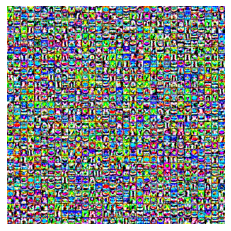

In [88]:
show_net_weights(best_net)

In [89]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.524
